# A Gentle Introduction to Continual Learning in PyTorch

In this brief tutorial we will learn the basics of *Continual Learning* using *PyTorch*. We will use the standard MNIST benchmark so that you can swiftly run this notebook from anywhere!

This notebook is part of the **[Continual AI Colab](https://github.com/ContinualAI/colab)** is a repository meant for tutorials and demo running on Google Colaboratory. [Continual AI](https://www.continualai.org/) is an open research community on the topic of Continual Learning and AI! Join us today [on slack](https://continualai.herokuapp.com/)! :-D

We will start with learning over the standard *MNIST* benchmark, then we will move in the actual continual learning setting  with the *Permuted MNIST* benchmark. Let's have some fun! :-)


---
** Connecting a local runtime**

In case resources are not enough for you (no GPU for example), you can always connect another [local runtime](https://research.google.com/colaboratory/local-runtimes.html) or to a [runtime on a Google Compute Engine instance](https://research.google.com/colaboratory/local-runtimes.html).

This notebook has been designed to run fast enough on simple CPUs so you shouldn't find any trouble here, using a free *hosted account*.

---


**Requisites to run it locally, outside colab (not recommended)**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---



## Google Colaboratory

First of all, take a moment to look around and discover Google Colab if you haven't before! You can run the commands below to understand how much resources you're using and are still available. Then consider also that you can also connect your Google Drive for additional space or for easily loading your own files.

You can always reset the entire VM with "*Runtime > Reset all runtime*" in case of difficulty. Make also sure you're using the GPU or TPU in the same  tab ("*Runtime > Change runtime type*").

In [ ]:
!free -m
!df -h
!nvidia-smi

               total        used        free      shared  buff/cache   available
Mem:           12982         614        6462           1        5905       12076
Swap:              0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   28G   51G  35% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  885M  55% /usr/sbin/docker-init
/dev/sda1        50G   30G   21G  60% /opt/bin/.nvidia
tmpfs           6.4G  388K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Mon Nov 27 16:08:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persisten

Ok, if you are on Colab PyTorch is already installed! Let's import it and see if it can find the GPU:

In [ ]:
import torch
torch.cuda.is_available()

True

That's great, let us import then a few libraries, which we'll be using during this tutorial!

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## MNIST: Digits recognition with PyTorch

All right, let's start then making sure we all know the basics! Let's recognize the ten handwritten digits learning from 60.000, 28x28 grayscale images.
For simplicity let's import a loading script we have already developed inside the **Continual AI Colab** repository:

In [ ]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

fatal: destination path 'continualai/colab' already exists and is not an empty directory.


In [ ]:
from continualai.colab.scripts import mnist
mnist.init()

Files already downloaded!


In [ ]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


Let's take a look at the actual images!

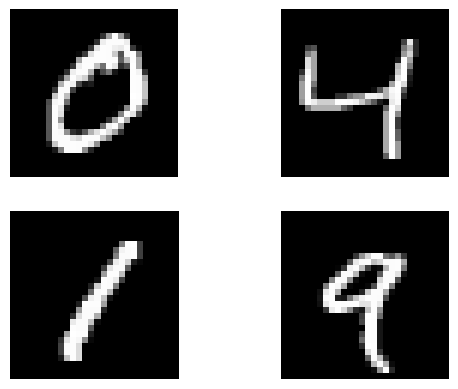

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Good! Let's now set up a few general setting before using torch...

In [ ]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

... and define our first conv-net! We will use 3 layers of convolutions and two fully connected layers:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # CONV 1:
        # input_channels = 1, output_channels = 10
        # size of each input channel = 28x28
        # stride = 1, kernel_size = 5x5
        # output size of each output channel: (28-5+1) x (28-5+1) = 24 x 24
        # MAX POOL 1:
        # stride = 2
        # output size of each channel: 12x12
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # CONV 2:
        # input_channels = 10, output_channels = 20
        # size of each input channel = 12x12
        # stride = 1, kernel_size = 5x5
        # output size of each output channel: (12-5+1) x (12-5+1) = 8 x 8
        # MAX POOL 2:
        # stride = 2x2
        # output size of each channel: 4x4
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        # (4x4) x 20 channels = 320
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Then we can write the *train* and *test* functions. Note that for simplicity here we are not using PyTorch [Data Loaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) but this is not recommended for efficiency.

In [ ]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Then we are ready to instantiate our model and start the training!

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.765683
Test set: Average loss: 0.0013, Accuracy: 9020/10000 (90%)

Train Epoch: 2 	Loss: 0.481925
Test set: Average loss: 0.0007, Accuracy: 9426/10000 (94%)



Wow! 94% accuracy in such a short time.

But what if now we want we the same model being able to solve a new task we encounter over time like a permuted version of the same MNIST? Let's define our custom function to permute it!

In [ ]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [ ]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

starting permutation...
done.


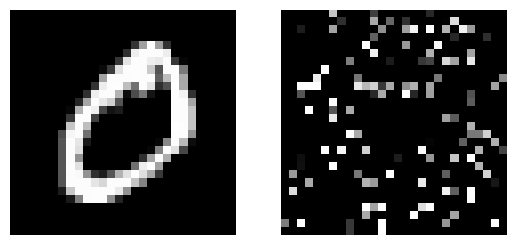

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Amazing. Now let's see how our pre-trained model is working on both the original and the permuted MNIST dataset:

In [ ]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0007, Accuracy: 9426/10000 (94%)

Testing on the second task:
Test set: Average loss: 0.0108, Accuracy: 1034/10000 (10%)



Mmmh... that's pretty bad, our model cannot generalize to this apparently very different new task! Well, we can just finetune our model using the new permuted training set!

In [ ]:
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 1.448701
Test set: Average loss: 0.0032, Accuracy: 7404/10000 (74%)

Train Epoch: 2 	Loss: 1.176130
Test set: Average loss: 0.0022, Accuracy: 8292/10000 (83%)



In [ ]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0208, Accuracy: 2391/10000 (24%)

Testing on the second task:
Test set: Average loss: 0.0022, Accuracy: 8292/10000 (83%)



This is very annoying! Now we are not able to solve the original MNIST task anymore! :-( This is the phenomenon known in literature as **Catastrophic Forgetting**! In the following section we well compare three different strategies for learning continually (and trying to not forget!)

## CL Strategies

Let us now focus on some strategies for reducing catastrofic forgetting, one of the principal problems when learning continuously. in this section we will take a look at two different strategies:

1.   Cumulative
3.   Random Replay
2.   Elastic Weight Consolidation (EWC)

and run it on a 3-tasks Permuted MNIST. Finally we will plot our results for comparison.
We compare the two strategies to the base one (Naive).
For a more comprehensive overview on recent CL strategies for deep learning take a look at the recent paper "[Continuous Learning in Single-Incremental-Task Scenarios](https://arxiv.org/abs/1806.08568)".

Let's start by defining our 3 tasks with the function we have already introduced before:



In [ ]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


In [ ]:
accs_table = {}
accs_table_random_model = {}

### Naive Strategy (Base strategy)

The  *Naive* strategy, is the simple idea of continuing the back-prop process on the new batches/tasks. This is very simple, but at the same time very prone to forgetting as we have witnessed before. Let's how it works on three tasks:

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# random model for fwt
accs_table_random_model["Naive"] = []
for id_test, task in enumerate(tasks):
  print("Testing on task: ", id_test+1)
  _, (x_test, t_test) = task
  acc = test(model, device, x_test, t_test)
  accs_table_random_model["Naive"].append(acc)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 924/10000 (9%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 656/10000 (7%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 1197/10000 (12%)



In [ ]:
naive_accs = []
accs_table["Naive"] = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("TRAINING on task: ", id+1)
  accs_table["Naive"].append([])

  (x_train, t_train), _ = task

  for epoch in range(1, 3):
    train(model, device, x_train, t_train, optimizer, epoch)

  print()
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test+1)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    accs_table["Naive"][-1].append(acc)
    avg_acc = avg_acc + acc

  naive_accs.append(avg_acc / 3)
  print("Avg acc: ", avg_acc / 3)
  print()


TRAINING on task:  1
Train Epoch: 1 	Loss: 0.659498
Train Epoch: 2 	Loss: 0.540133

Testing on task:  1
Test set: Average loss: 0.0007, Accuracy: 9485/10000 (95%)

Testing on task:  2
Test set: Average loss: 0.0113, Accuracy: 675/10000 (7%)

Testing on task:  3
Test set: Average loss: 0.0098, Accuracy: 1385/10000 (14%)

Avg acc:  38.48333333333333

TRAINING on task:  2
Train Epoch: 1 	Loss: 1.845170
Train Epoch: 2 	Loss: 1.262561

Testing on task:  1
Test set: Average loss: 0.0176, Accuracy: 2031/10000 (20%)

Testing on task:  2
Test set: Average loss: 0.0030, Accuracy: 7757/10000 (78%)

Testing on task:  3
Test set: Average loss: 0.0124, Accuracy: 1177/10000 (12%)

Avg acc:  36.55

TRAINING on task:  3
Train Epoch: 1 	Loss: 1.251475
Train Epoch: 2 	Loss: 1.200687

Testing on task:  1
Test set: Average loss: 0.0202, Accuracy: 2258/10000 (23%)

Testing on task:  2
Test set: Average loss: 0.0080, Accuracy: 2843/10000 (28%)

Testing on task:  3
Test set: Average loss: 0.0023, Accuracy: 83

### Cumulative Strategy

Another simple CL idea is to carry on *all* or *part* of the previously encountered examples (of the previous tasks), shuffling them with the data of the current task. Using *all* the past data is near to the optimal performance we can desire at the end of the task sequence but at the expense of much bigger memory usage.

Let's start by defining a function to shuffle our data:



In [ ]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Now we can reset the model and optimizer and run our training over the tasks sequence:

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
accs_table_random_model["Cumulative"] = []
for id_test, task in enumerate(tasks):
  print("Testing on task: ", id_test+1)
  _, (x_test, t_test) = task
  acc = test(model, device, x_test, t_test)
  accs_table_random_model["Cumulative"].append(acc)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 1032/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 1032/10000 (10%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 1032/10000 (10%)



In [ ]:
cum_accs = []
accs_table["Cumulative"] = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("TRAINING on task: ", id+1)
  accs_table["Cumulative"].append([])

  (x_train, t_train), _ = task

  # for previous task
  for i in range(id):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))

  x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

  for epoch in range(1, 3):
    train(model, device, x_train, t_train, optimizer, epoch)

  print()
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test+1)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    accs_table["Cumulative"][-1].append(acc)
    avg_acc = avg_acc + acc

  print("Avg acc: ", avg_acc / 3)
  print()
  cum_accs.append(avg_acc/3)

TRAINING on task:  1
Train Epoch: 1 	Loss: 0.602858
Train Epoch: 2 	Loss: 0.259049

Testing on task:  1
Test set: Average loss: 0.0007, Accuracy: 9461/10000 (95%)

Testing on task:  2
Test set: Average loss: 0.0114, Accuracy: 610/10000 (6%)

Testing on task:  3
Test set: Average loss: 0.0097, Accuracy: 1314/10000 (13%)

Avg acc:  37.949999999999996

TRAINING on task:  2
Train Epoch: 1 	Loss: 0.802614
Train Epoch: 2 	Loss: 0.600242

Testing on task:  1
Test set: Average loss: 0.0005, Accuracy: 9622/10000 (96%)

Testing on task:  2
Test set: Average loss: 0.0021, Accuracy: 8539/10000 (85%)

Testing on task:  3
Test set: Average loss: 0.0107, Accuracy: 1332/10000 (13%)

Avg acc:  64.97666666666667

TRAINING on task:  3
Train Epoch: 1 	Loss: 0.306301
Train Epoch: 2 	Loss: 0.492935

Testing on task:  1
Test set: Average loss: 0.0005, Accuracy: 9613/10000 (96%)

Testing on task:  2
Test set: Average loss: 0.0016, Accuracy: 8827/10000 (88%)

Testing on task:  3
Test set: Average loss: 0.0019,

### Random Replay strategy

Random Replay is a CL strategy that uses a fixed-size Random Memory (RM) to store a subset of random previous experiences' data points. During the training on the i-th experience, it trains the model on the i-th training set shuffled with a fixed-size Random Memory (RM). RM contains a random subset of the data points of the previous experiences' training sets. After the training, it randomly substitutes some data points with a random subset of the current experience's training set in RM. This way, RM will be updated for the next experience and maintain an approximately equal number of examples for each experience.

In [ ]:
x_train.shape[1:]

(1, 28, 28)

In [ ]:
# Function to compute the Random Memory
def compute_rm(X_train, y_train, rm_size, id_task, X_rm_old, y_rm_old):
  np.random.seed(42)

  h = int(rm_size / (id_task+1))
  # Generate h random indices for sampling
  random_indices = np.random.choice(rm_size, h, replace=False)

  # Shuffle train dataset otherwise random indices will consider only the first rm_size elements of X_train and y_train
  shuffled_index = np.random.permutation(len(X_train))
  X_shuffled = X_train[shuffled_index]
  y_shuffled = y_train[shuffled_index]

  # Handle initial case of empty RM - initialize with random numbers
  if X_rm_old.size == 0:
    X_rm_old = np.empty(
        (rm_size,
         X_train.shape[1],
         X_train.shape[2],
         X_train.shape[3]
    ), dtype=np.float32)
    y_rm_old = np.empty((rm_size, ))

  # Substitute h values of old RM with h values of current training set
  X_rm_new = X_rm_old
  y_rm_new = y_rm_old
  for idx in random_indices:
    X_rm_new[idx] = X_shuffled[idx]
    y_rm_new[idx] = y_shuffled[idx]

  return X_rm_new, y_rm_new


# Concatenate and shuffle training data with Random Memory
def concat_shuffle_rm(X_data, y_data, X_rm_data, y_rm_data):
  # Handle case of first experience
  if X_rm_data.size == 0:
    return X_data, y_data

  X_concat = np.concatenate((X_data, X_rm_data), axis=0)
  y_concat = np.concatenate((y_data, y_rm_data), axis=0)

  np.random.seed(42)
  shuffled_index = np.random.permutation(len(X_concat))
  # Shuffle X and y using the shuffled index
  X_new = X_concat[shuffled_index]
  y_new = y_concat[shuffled_index]

  return X_new, y_new


Let's set the random memory size to 20% of each experience's train set.

In [ ]:
(x_train, _), _ = tasks[0]
rm_size = int(0.2*x_train.shape[0])

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
accs_table_random_model["Replay"] = []
for id_test, task in enumerate(tasks):
  print("Testing on task: ", id_test+1)
  _, (x_test, t_test) = task
  acc = test(model, device, x_test, t_test)
  accs_table_random_model["Replay"].append(acc)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 1024/10000 (10%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 1028/10000 (10%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 1029/10000 (10%)



In [ ]:
repl_accs = []
accs_table["Replay"] = []

# Initialize Random Memory
X_rm = np.array([])
y_rm = np.array([])

# Training on i-th task using data from i-th experience shuffled with RM
for id, task in enumerate(tasks):
  avg_acc = 0
  print("TRAINING on task: ", id+1)
  accs_table["Replay"].append([])

  (x_train, y_train), _ = task

  x_train_replay, y_train_replay = concat_shuffle_rm(x_train, y_train, X_rm, y_rm)
  print("Dataset size: ", x_train_replay.shape, y_train_replay.shape)
  for epoch in range(1, 3):
    train(model, device, x_train_replay, y_train_replay, optimizer, epoch)

  # Update RM after training on i-th experience
  X_rm, y_rm = compute_rm(x_train, y_train, rm_size, id, X_rm, y_rm)

  # Testing on all tasks
  print()
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test+1)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    accs_table["Replay"][-1].append(acc)
    avg_acc = avg_acc + acc

  repl_accs.append(avg_acc / len(tasks))
  print("Average accuracy: ", avg_acc / len(tasks))
  print()

TRAINING on task:  1
Dataset size:  (60000, 1, 28, 28) (60000,)
Train Epoch: 1 	Loss: 0.671872
Train Epoch: 2 	Loss: 0.447127

Testing on task:  1
Test set: Average loss: 0.0007, Accuracy: 9423/10000 (94%)

Testing on task:  2
Test set: Average loss: 0.0115, Accuracy: 634/10000 (6%)

Testing on task:  3
Test set: Average loss: 0.0095, Accuracy: 1211/10000 (12%)

Average accuracy:  37.56

TRAINING on task:  2
Dataset size:  (72000, 1, 28, 28) (72000,)
Train Epoch: 1 	Loss: 1.018835
Train Epoch: 2 	Loss: 1.008889

Testing on task:  1
Test set: Average loss: 0.0010, Accuracy: 9304/10000 (93%)

Testing on task:  2
Test set: Average loss: 0.0022, Accuracy: 8416/10000 (84%)

Testing on task:  3
Test set: Average loss: 0.0113, Accuracy: 1025/10000 (10%)

Average accuracy:  62.48333333333333

TRAINING on task:  3
Dataset size:  (72000, 1, 28, 28) (72000,)
Train Epoch: 1 	Loss: 1.092075
Train Epoch: 2 	Loss: 0.854106

Testing on task:  1
Test set: Average loss: 0.0012, Accuracy: 9181/10000 (92%

### Elastic Weights Consolidation (EWC) Strategy

Elastic Weights Consolidation (EWC) is a common CL strategy firstly proposed in the paper: "[Overcoming catastrophic forgetting in neural networks](https://arxiv.org/abs/1612.00796)" for deep neural networks.

It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important wheights for the previous tasks.

It has the great advantage of **not using any** of the previous tasks data!

In [ ]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9)

Now we need to define an additional function to compute the fisher information for each weight at the end of each task:

In [ ]:
accs_table_random_model["EWC"] = []
for id_test, task in enumerate(tasks):
  print("Testing on task: ", id_test+1)
  _, (x_test, t_test) = task
  acc = test(model, device, x_test, t_test)
  accs_table_random_model["EWC"].append(acc)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 874/10000 (9%)

Testing on task:  2
Test set: Average loss: 0.0092, Accuracy: 1004/10000 (10%)

Testing on task:  3
Test set: Average loss: 0.0092, Accuracy: 1117/10000 (11%)



In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()

  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():

    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We need also to modify our *train* function to add the new regularization loss:

In [ ]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)

      ### magic here! :-)
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda

      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Finally we can run the train over the three tasks sequence of th *Permuted MNIST*:

In [ ]:
ewc_accs = []
accs_table["EWC"] = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("TRAINING on task: ", id+1)
  accs_table["EWC"].append([])

  (x_train, t_train), _ = task

  for epoch in range(1, 3):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
  on_task_update(id, x_train, t_train)

  print()
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test+1)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    accs_table["EWC"][-1].append(acc)
    avg_acc = avg_acc + acc

  print("Avg acc: ", avg_acc / 3)
  print()
  ewc_accs.append(avg_acc / 3)

TRAINING on task:  1
Train Epoch: 1 	Loss: 0.797689
Train Epoch: 2 	Loss: 0.633510

Testing on task:  1
Test set: Average loss: 0.0008, Accuracy: 9354/10000 (94%)

Testing on task:  2
Test set: Average loss: 0.0117, Accuracy: 648/10000 (6%)

Testing on task:  3
Test set: Average loss: 0.0101, Accuracy: 1034/10000 (10%)

Avg acc:  36.78666666666667

TRAINING on task:  2
Train Epoch: 1 	Loss: 1.986858
Train Epoch: 2 	Loss: 1.548838

Testing on task:  1
Test set: Average loss: 0.0081, Accuracy: 4964/10000 (50%)

Testing on task:  2
Test set: Average loss: 0.0037, Accuracy: 7364/10000 (74%)

Testing on task:  3
Test set: Average loss: 0.0107, Accuracy: 1480/10000 (15%)

Avg acc:  46.02666666666667

TRAINING on task:  3
Train Epoch: 1 	Loss: 2.182421
Train Epoch: 2 	Loss: 1.767791

Testing on task:  1
Test set: Average loss: 0.0076, Accuracy: 5591/10000 (56%)

Testing on task:  2
Test set: Average loss: 0.0083, Accuracy: 2977/10000 (30%)

Testing on task:  3
Test set: Average loss: 0.0038, 

### Plot Results

To conclude, let's summerize our results in a nice plot! :-)

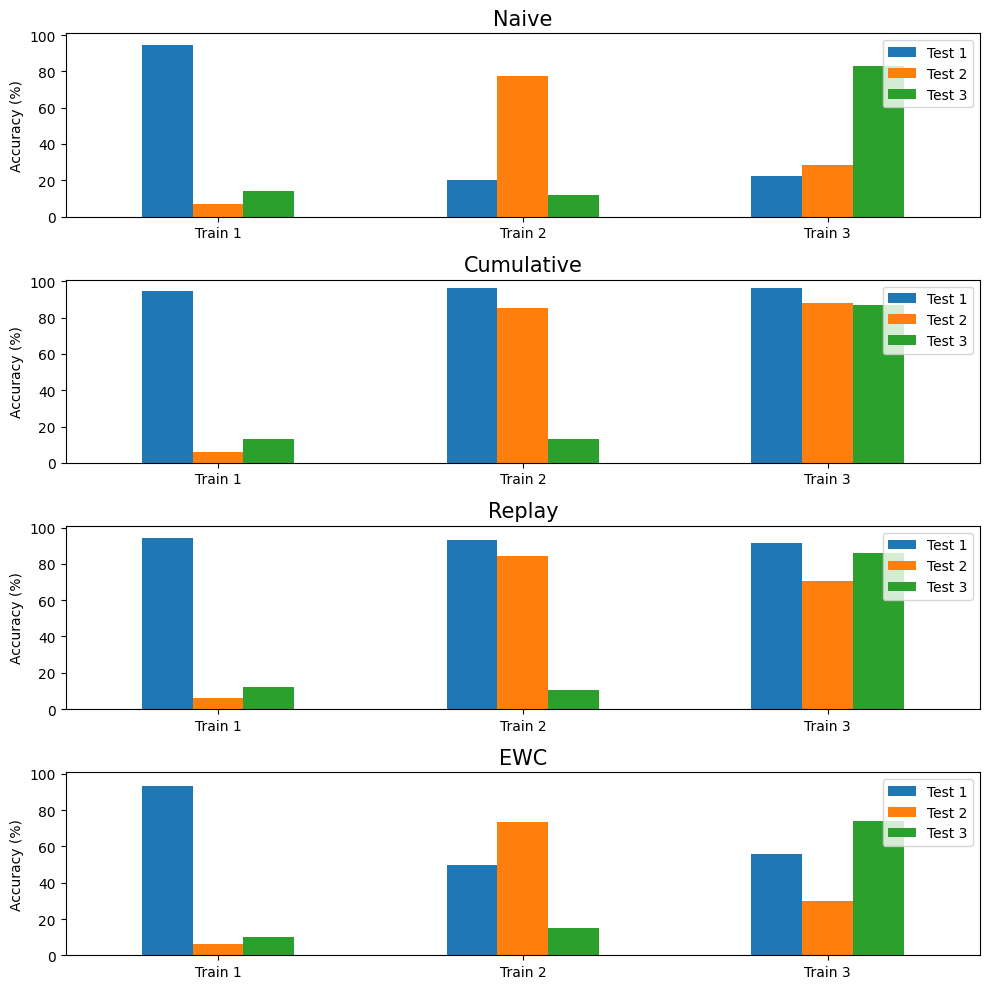

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(10,10), sharey=True)

for i, strategy in enumerate(accs_table):
  index = ["Train "+str(i) for i in range(1,4)]
  df_dict = {"Test "+str(i) : np.asarray(accs_table[strategy])[:,i-1] for i in range(1,4)}
  df = pd.DataFrame(df_dict, index=index)
  df.plot.bar(rot=0, ax=ax[i])
  ax[i].set_title(strategy, fontsize=15)
  ax[i].set_ylabel("Accuracy (%)")
plt.tight_layout()

### How to derive insights using the plot

To check for ***plasticity*** we must check if the model is able to learn the current experience. For the first experience, we examine whether the model achieves accuracy greater than 1/n_classes on the test set of the current experience. For subsequent experiences, we assess whether the model, trained on the current experience, not only surpasses the 1/n_classes accuracy threshold on its test set but also outperforms the model trained on the preceding experience.

***BWT*** metric is a general metric that considers the model trained on the last experience. On the other hand, when we use the plot, we can see how the model performs on all the trainings that happened before. After training on experience i, we check if the model's performance gets better or worse compared to training i-1 for different experiences j where j<i.


The FWT metric is a general measure that assesses the model trained after the current experience, tested on the subsequent experience, and compares it with a randomly initialized model. When examining the plot, we can observe how the current training performs across all experiences that follow. After training on the first experience, we compare the current model's performance with a randomly initialized model that predicts classes with an accuracy of 1/n_classes on all test sets for experiences j where j > 1. In addition to this, in subsequent trainings on experiences i, we also evaluate whether the model's performance improves or worsens compared to training i-1, considering all the test sets for experiences j where j > i.

______
In this specific case:



*   Cumulative is the only strategy that does not forget the past tasks. It has also backward transfer (performance on old tasks improves).
*   All the strategies have plasticity (performance on the new task always improve significantly and has an accuracy>0.5).
*   No strategy has a significative forward transfer (performances on future tasks do not improve significantly).
*   Replay performs better than EWC and uses low data w.r.t. Cumulative, which is not appliable in the real world.
*  EWC is not able to find a balance between the different tasks.

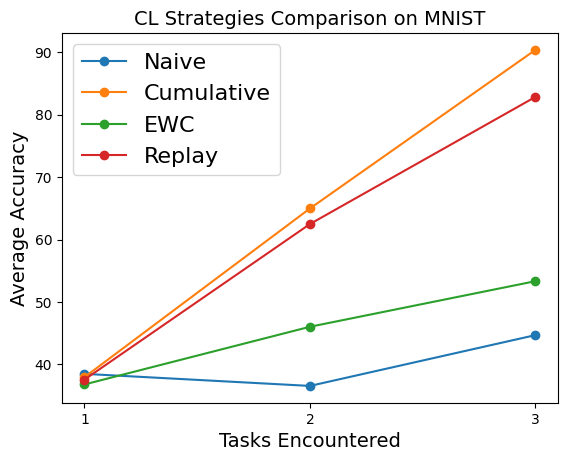

In [ ]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], cum_accs, '-o', label="Cumulative")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.plot([1, 2, 3], repl_accs, '-o', label="Replay")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNIST', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

### A_METRIC

In [ ]:
a_metric = {}
for strategy in accs_table:
  a_metric[strategy] = 0
  for i in range(0,3):
    for j in range(0,i+1):
      a_metric[strategy] += accs_table[strategy][i][j]
  a_metric[strategy] /= 3*(3+1)/2
a_metric

{'Naive': 54.465,
 'Cumulative': 91.22833333333331,
 'Replay': 86.66333333333334,
 'EWC': 62.80166666666667}

## FWT metric

In [ ]:
fwt = {}
for strategy in accs_table:
  fwt[strategy] = 0
  for i in range(1,3):
    fwt[strategy] += (
        accs_table[strategy][i-1][i] -
        accs_table_random_model[strategy][i]
    )
  fwt[strategy] /= 2
fwt

{'Naive': -0.0050000000000003375,
 'Cumulative': -0.6100000000000003,
 'Replay': -1.9899999999999993,
 'EWC': 0.03500000000000103}

## BWT metric

In [ ]:
bwt = {}
for strategy in accs_table:
  bwt[strategy] = 0
  for i in range(0,2):
    bwt[strategy] += (
        accs_table[strategy][-1][i] -
        accs_table[strategy][i][i]
    )
  bwt[strategy] /= 2
bwt

{'Naive': -60.705,
 'Cumulative': 2.1999999999999957,
 'Replay': -7.894999999999996,
 'EWC': -40.75000000000001}

**Copyright (c) 2018. Continual AI. All rights reserved. **

See the accompanying LICENSE file in the GitHub repository for terms.

*Date: 29-09-2018                                                             
Author: Vincenzo Lomonaco                                                    
E-mail: contact@continualai.org                                           
Website: continualai.org*                                               

Original Notebook: https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb